## Этап 1. Подготовка данных

### Этап 1.1. Импорт библиотек и загрузка данных

In [31]:
# установим свежий scikit-learn для поддержки в OneHotEncoder одновременно drop='first' и handle_unknown='ignore'
!pip install scikit-learn==1.1.3
!pip install catboost

# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

# отобразим все строки в таблицах
pd.set_option('display.max_rows', None)

# отключим предупреждения
import warnings
warnings.filterwarnings("ignore")

# зафиксируем значение random state
RS = 12345

In [32]:
# загрузим данные из локальной папки
data = pd.read_csv('autos.csv')

# напишем функцию для проверки датасета
def check(df):
    display(
            # Проверим общую информацию о датасете
            df.info(),
            df.head().T,
            df.describe(include='all').T,
    )
    # Проверим строки на дубликаты
    print('Полных дубликатов строк:', df.duplicated().sum())

    # Проверим признаки на корреляцию
    sns.set(rc = {'figure.figsize':(23,20)})
    sns.heatmap(df.corr());

    # Проверим распределение значений в столбцах
    df.hist()

### Этап 1.2. Обзор датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Полных дубликатов строк: 4


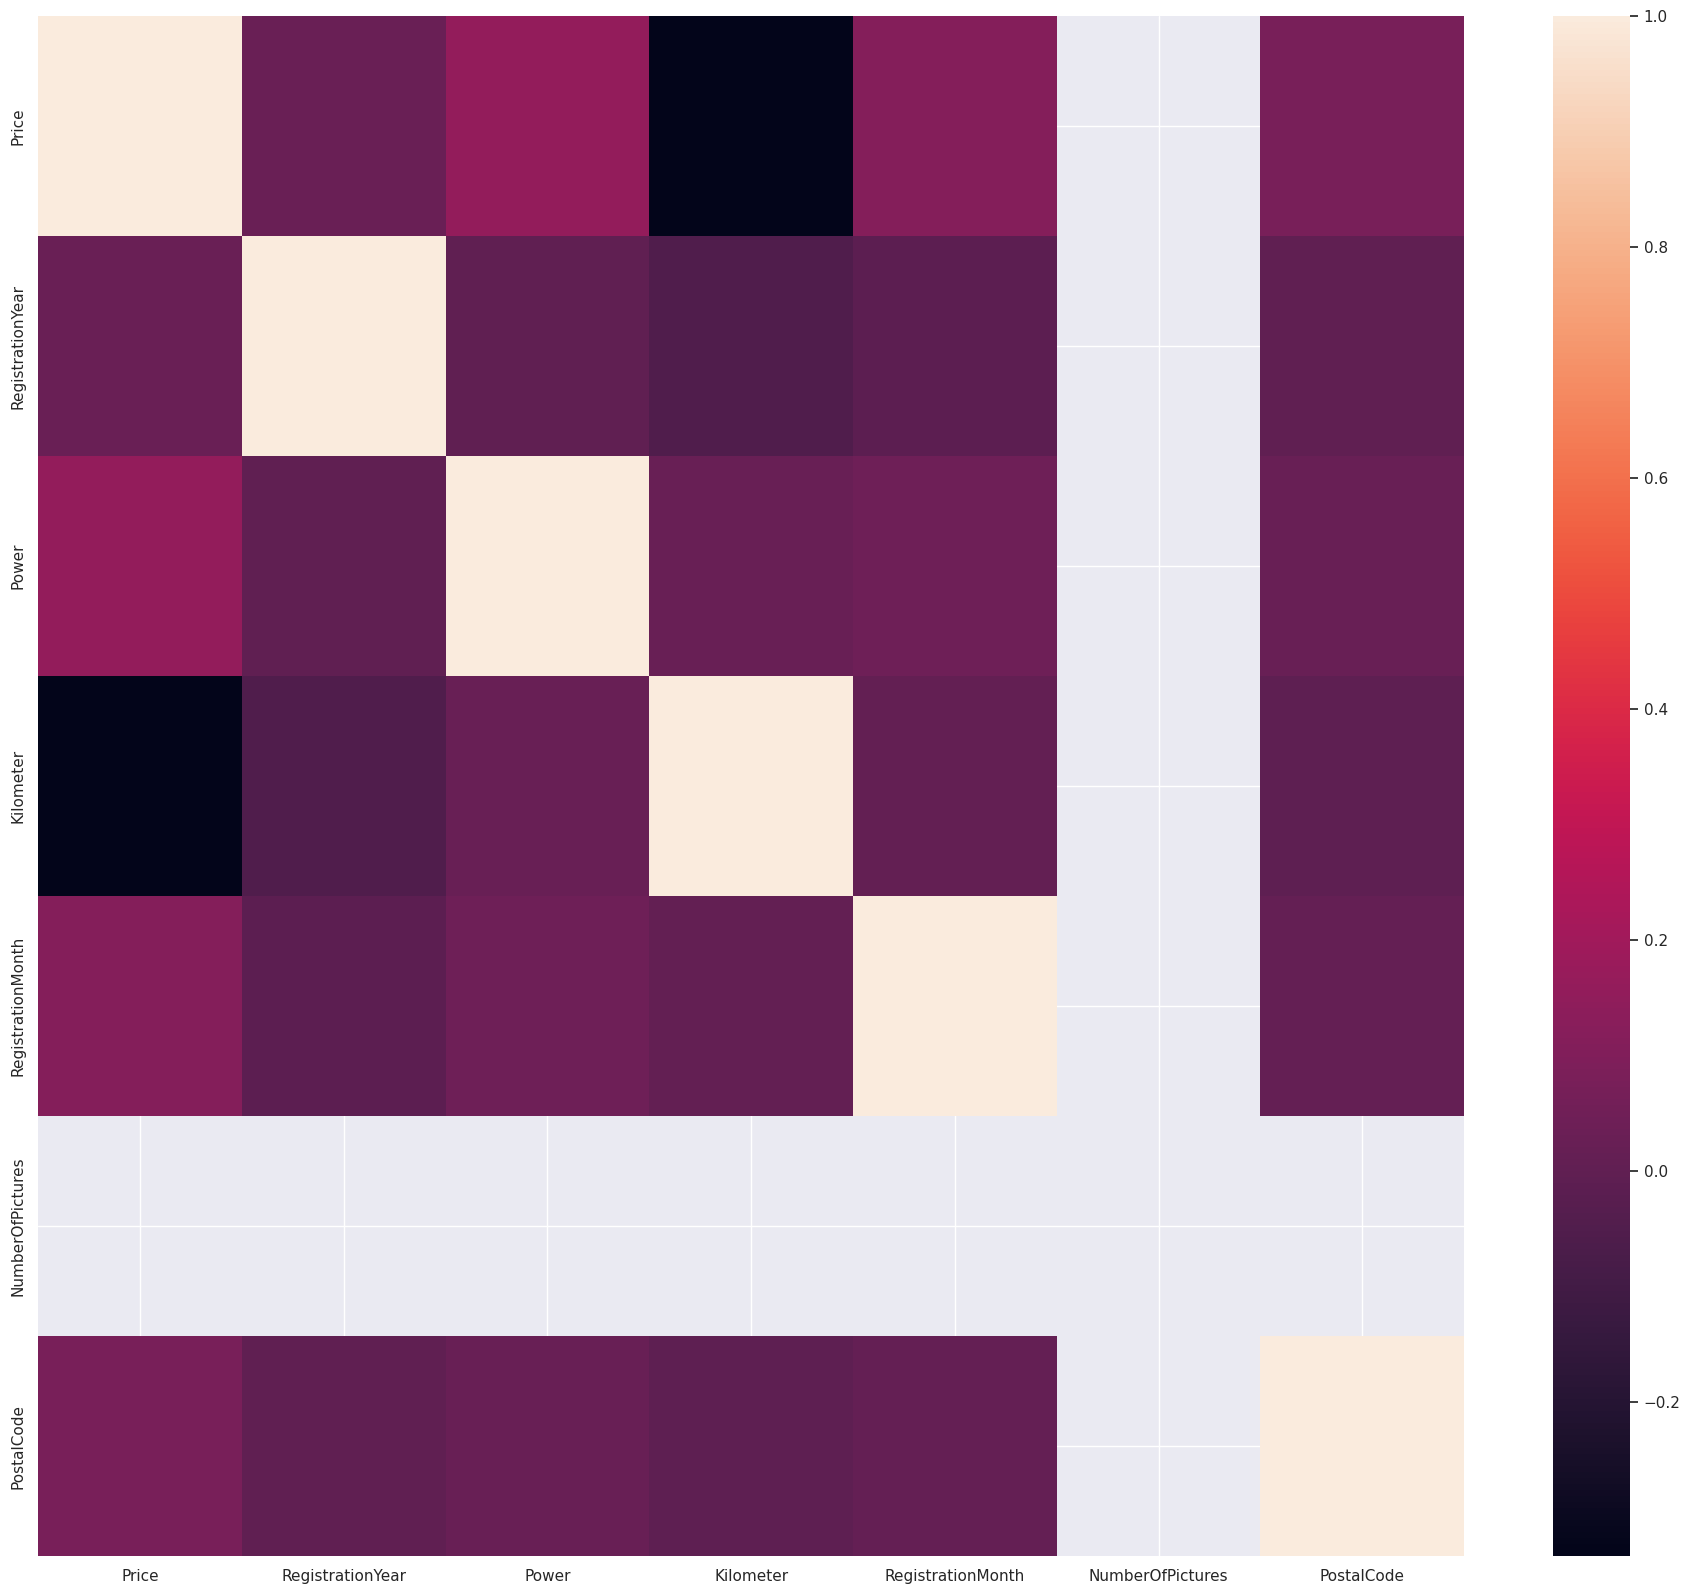

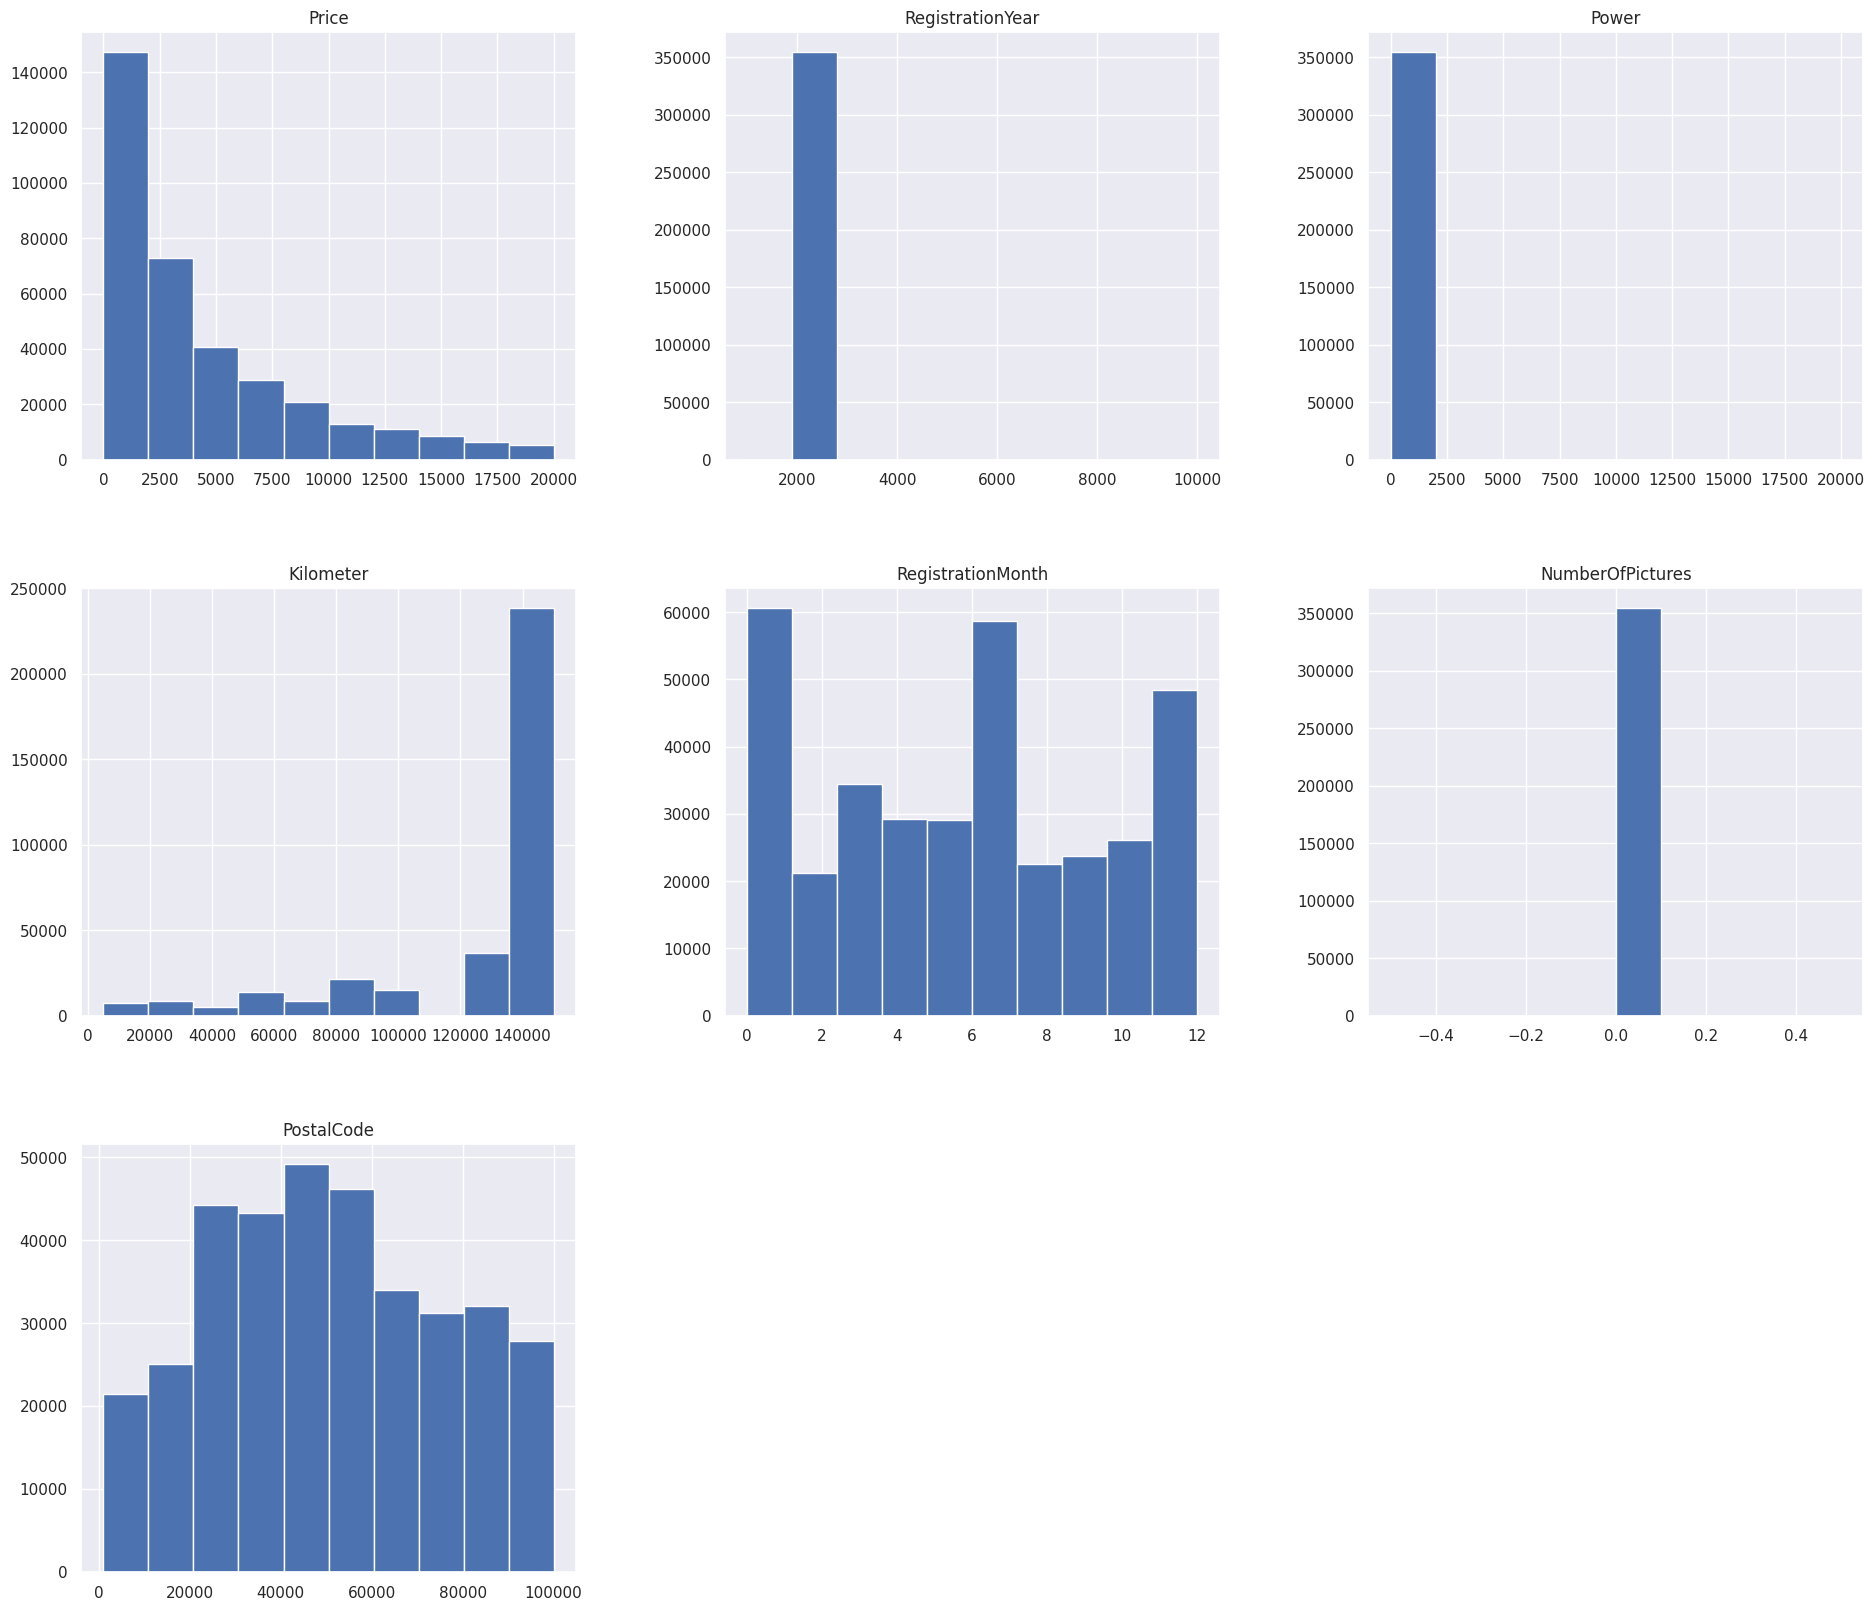

In [33]:
# проверим датасет
check(data)

- Во столбцах с данными типа object нужно перевести информацию в тип category

- Пропуски в столбцах:
    - VehicleType
    - Gearbox
    - Model
    - FuelType
    - Repaired

- Аномальные значения в столбцах:
    - Price: нулевые значения цены. Большая часть цен сосредоточена в диапазоне до 10 000 евро: вероятно, значения выше этого порога будут аномальны.
    - RegistrationYear: неадекватные значения, например 1000 г. или 9999 г.
    - Kilometer: подавляющиее количество машин имеет пробег свыше 140 000 км, поэтому пробеги ниже этого порога вероятно будут аномальны.
    - Power: неадекватные значения, например 0 или 20 000 л.с.
    - RegistrationMonth: нулевые значения месяца при наличии значений от 1 до 12.
    
- Неинформативные столбцы, бесполезные при решении задачи:
    - DateCrawled
    - DateCreated
    - NumberOfPictures
    - PostalCode
    - LastSeen
    
- В датасете 4 полных дубликата строк

- Признаки не коррелируют между собой

### Этап 1.3. Удаление неинформативных столбцов

In [34]:
# удалим бесполезные для нашей задачи столбцы
df = data.drop(['DateCrawled',
                'DateCreated',
                'NumberOfPictures',
                'PostalCode',
                'LastSeen'
               ],
               axis=1
    )

# проверим результат
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

### Этап 1.4. Изменение типа категориальных данных

In [35]:
# поменяем тип данных в категориальных признаках с object на category
cat_features = df.select_dtypes(include=object).columns.tolist()
df[cat_features] = df[cat_features].astype('category')

# проверим результат
df.dtypes

Price                   int64
VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                   int64
Model                category
Kilometer               int64
RegistrationMonth       int64
FuelType             category
Brand                category
Repaired             category
dtype: object

### Этап 1.5. Обработка дубликатов

In [36]:
# проверим строки на дубликаты после удаления столбцов
print('Полных дубликатов строк:', df.duplicated().sum())

Полных дубликатов строк: 27543


In [37]:
# удалим полные дубликаты строк
df = df.drop_duplicates()

# проверим результат
df.shape[0]

326826

### Этап 1.6. Обработка аномалий

#### Этап 1.6.1. Обработка цен

In [38]:
# удалим нулевые цены
df = df[df['Price'] != 0]

# проверим результат
display(
    df[df['Price'] == 0],
    df.shape[0]
)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired


317439

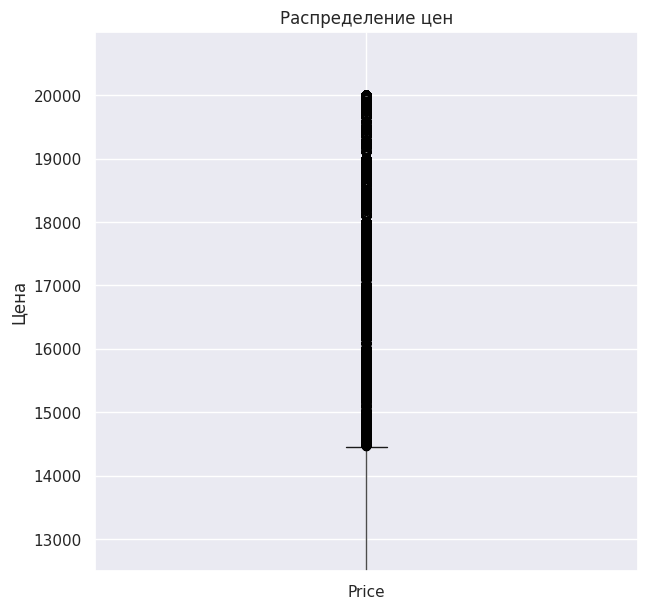

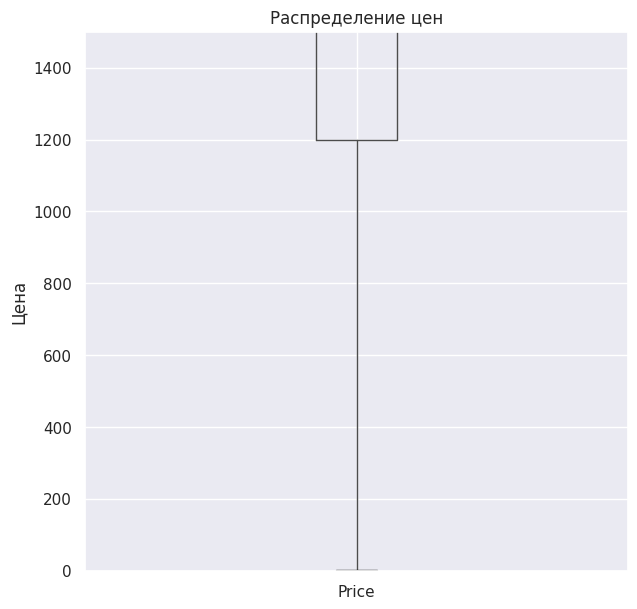

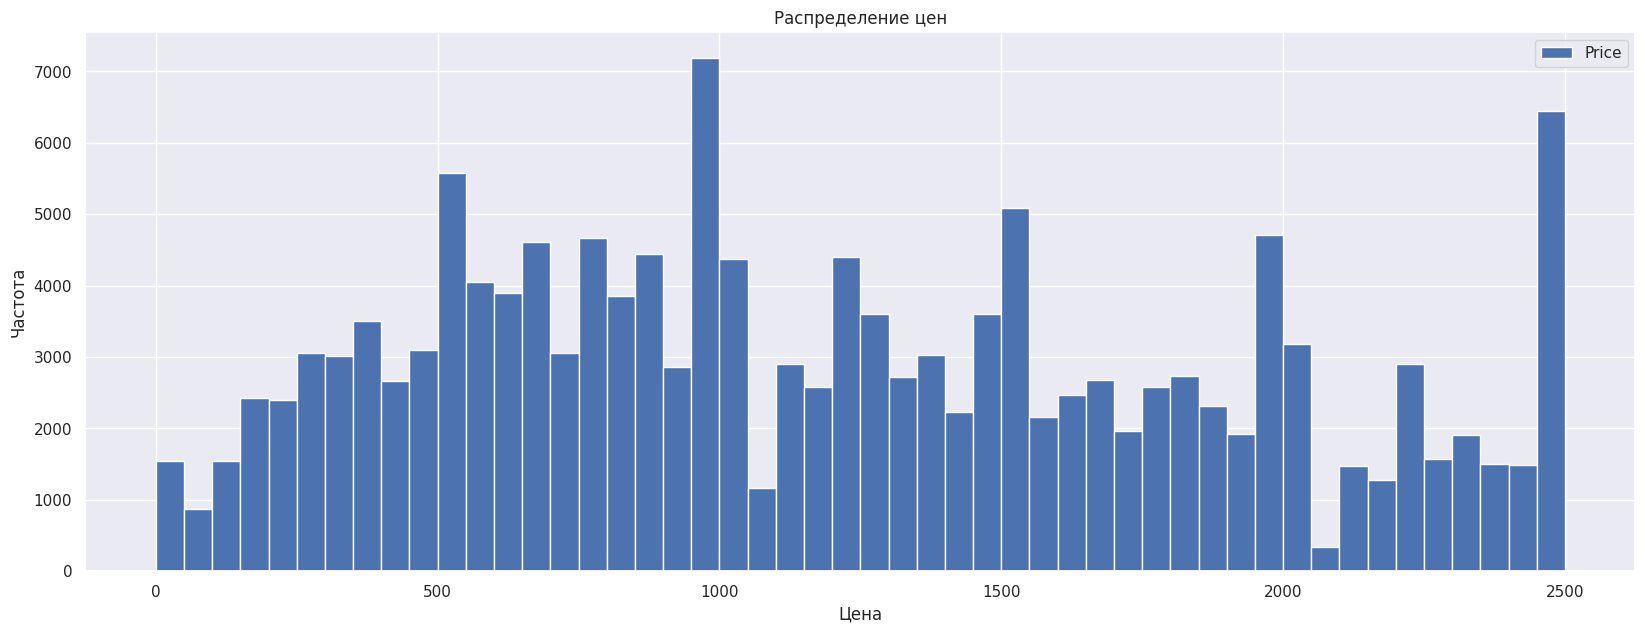

In [39]:
# проверим большие значения Price на аномалии
plt.figure(figsize=(7, 7))
df.boxplot(column='Price')
plt.title('Распределение цен')
plt.ylabel('Цена')
plt.ylim(12500, )
plt.show()

# проверим малые значения Price на аномалии
plt.figure(figsize=(7, 7))
df.boxplot(column='Price')
plt.title('Распределение цен')
plt.ylabel('Цена')
plt.ylim(0, 1500)
plt.show()

# посмотрим на общее распределение цен
plt.figure(figsize=(20, 7))
df['Price'].plot(kind='hist',
                 range=(0, 2500),
                 bins=50,
                 grid=True,
                 legend=True
            )
plt.title('Распределение цен')
plt.ylabel('Частота')
plt.xlabel('Цена')
plt.show()

In [40]:
# найдем долю аномальных цен (выше 14 500 евро и ниже 250 евро) и выведем размер датасета
display(
    df[(df['Price'] > 14500) |
       (df['Price'] < 250)
    ].shape[0] / df.shape[0],
    df.shape[0]
)

0.0797980084362665

317439

In [41]:
# удалим аномальные цены
df = df[(df['Price'] <= 14500) &
        (df['Price'] >= 250)
    ]

# проверим результат
df.shape[0]

292108

#### Этап 1.6.2. Обработка года регистрации

In [42]:
# удалим строки с годом регистрации больше 2023
df = df[df['RegistrationYear'] <= 2016]

# проверим результат
df.shape[0]

279460

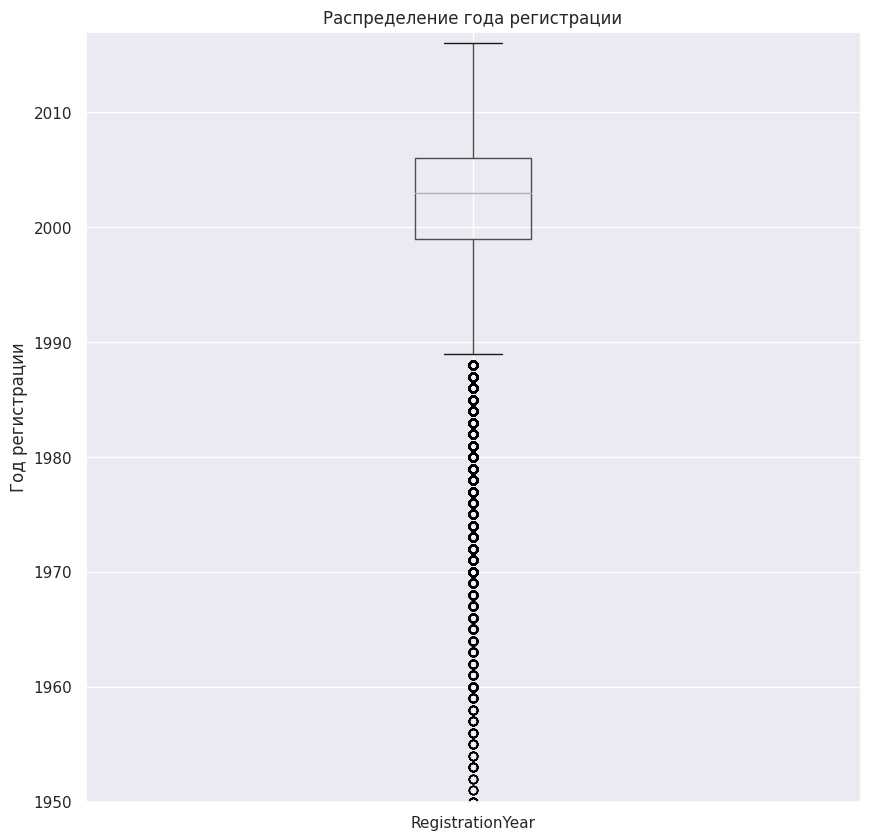

In [43]:
# проверим малые значения RegistrationYear на аномалии
plt.figure(figsize=(10, 10))
df.boxplot(column='RegistrationYear')
plt.title('Распределение года регистрации')
plt.ylabel('Год регистрации')
plt.ylim(1950, 2017)
plt.show()

In [44]:
# проверим долю аномально малых значений года регистрации
df[df['RegistrationYear'] < 1987].shape[0] / df.shape[0]

0.018288842768195805

In [45]:
# удалим аномально низкие значения года регистрации
df = df[df['RegistrationYear'] >= 1987]

# проверим результат
df.shape[0]

274349

#### Этап 1.6.3. Обработка пробега

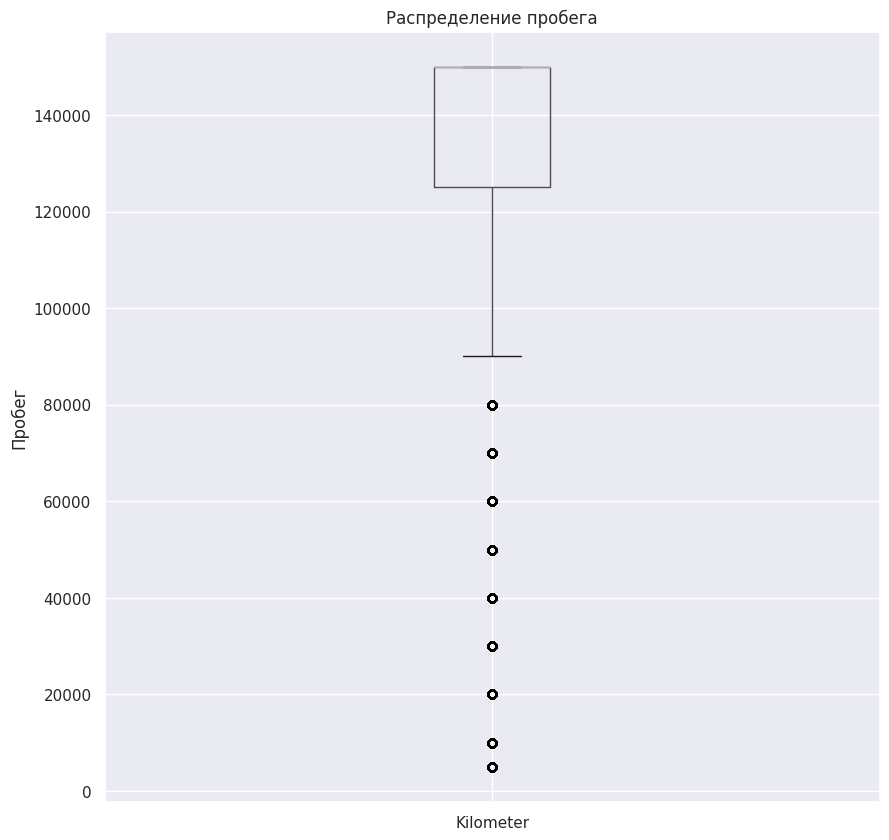

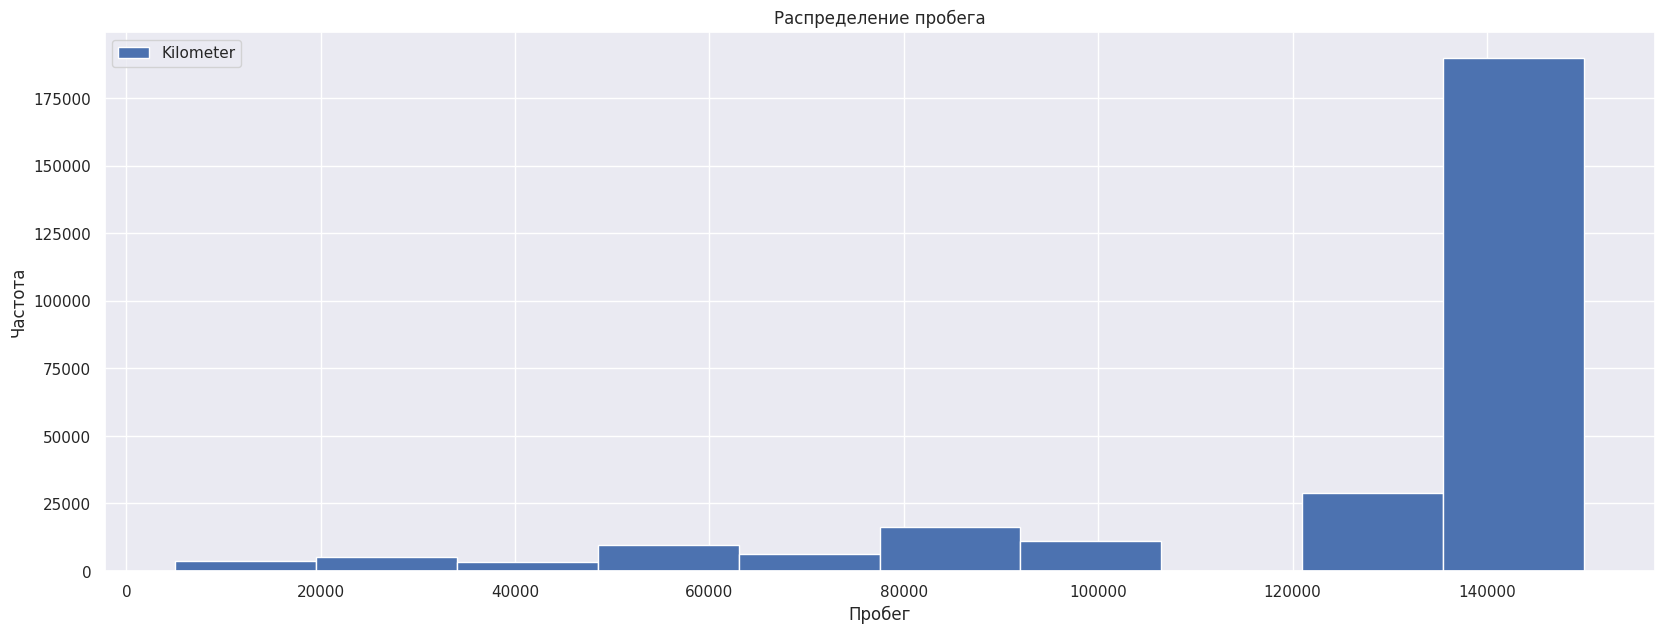

In [46]:
# проверим выбросы значений пробега
plt.figure(figsize=(10, 10))
df.boxplot(column='Kilometer')
plt.title('Распределение пробега')
plt.ylabel('Пробег')
plt.show()

# посмотрим на общее распределение пробега
plt.figure(figsize=(20, 7))
df['Kilometer'].plot(kind='hist',
                     bins=10,
                     grid=True,
                     legend=True
                )
plt.title('Распределение пробега')
plt.ylabel('Частота')
plt.xlabel('Пробег')
plt.show()

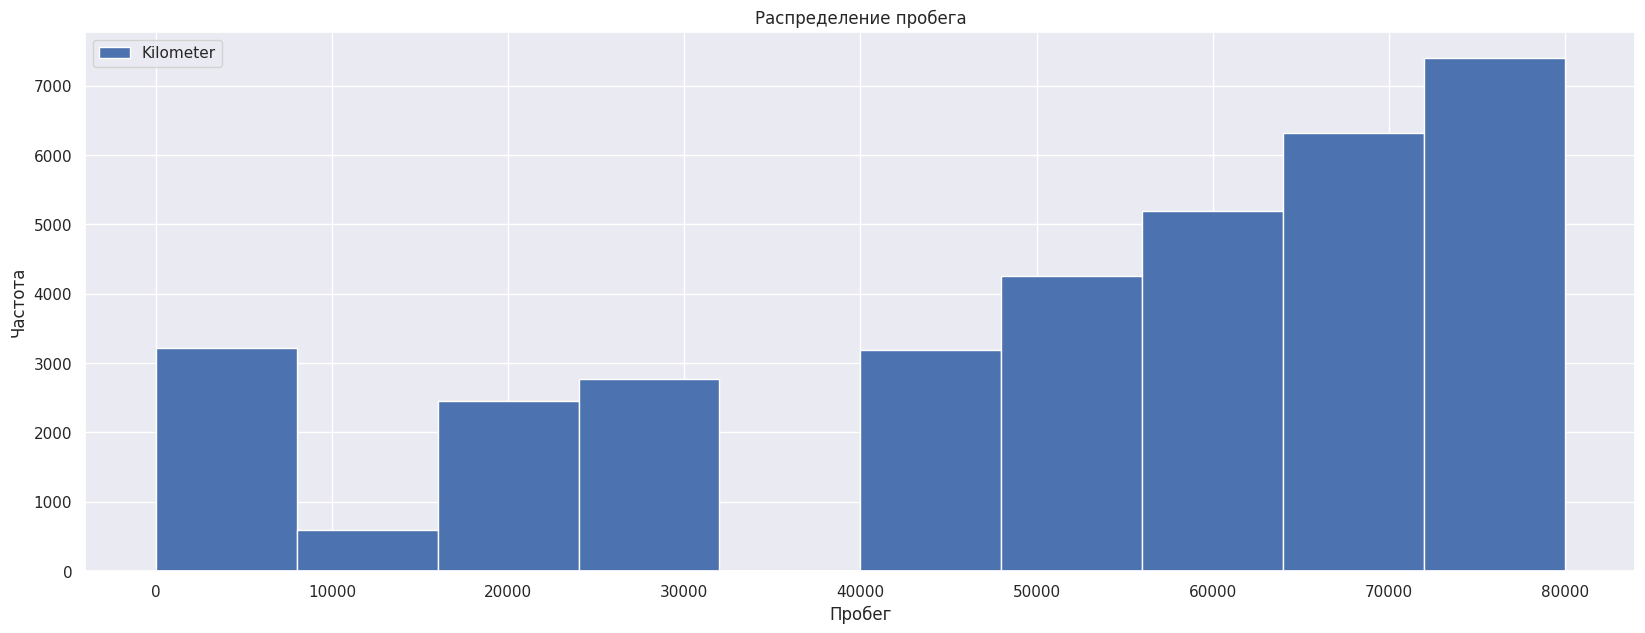

In [47]:
# посмотрим на распределение небольших значений пробега
plt.figure(figsize=(20, 7))
df['Kilometer'].plot(kind='hist',
                     bins=10,
                     range=(0, 80000),
                     grid=True,
                     legend=True
                )
plt.title('Распределение пробега')
plt.ylabel('Частота')
plt.xlabel('Пробег')
plt.show()

In [48]:
# проверим долю аномально низких значений пробега
df[df['Kilometer'] < 40000].shape[0] / df.shape[0]

0.032928860684748255

In [49]:
# удалим аномально низкие значения пробега
df = df[df['Kilometer'] >= 40000]

# проверим результат
df.shape[0]

265315

#### Этап 1.6.4. Обработка мощности

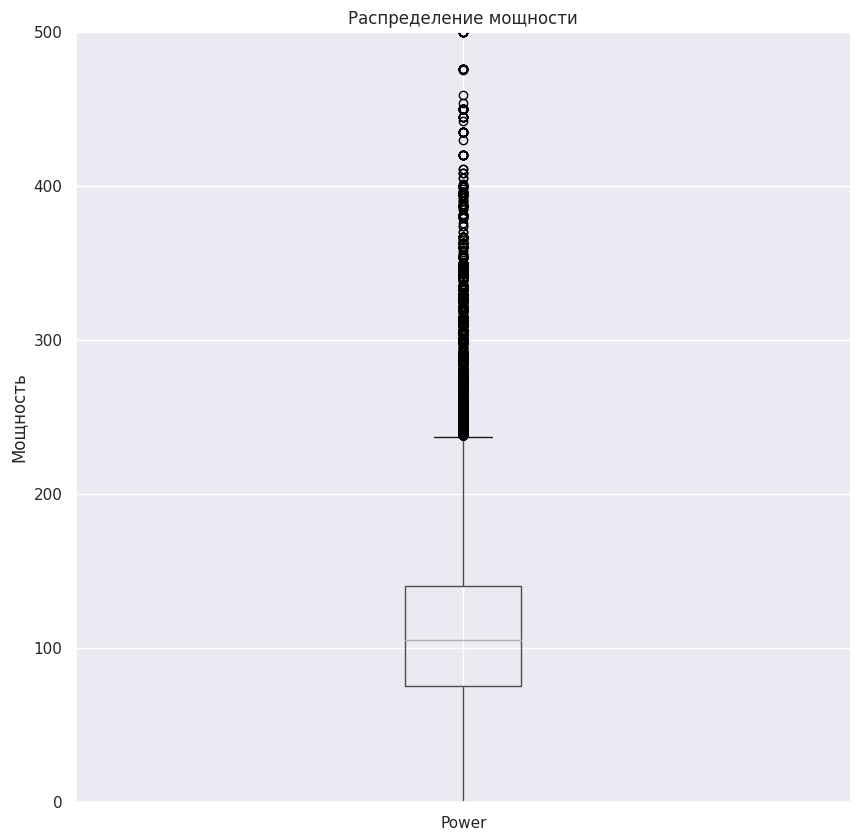

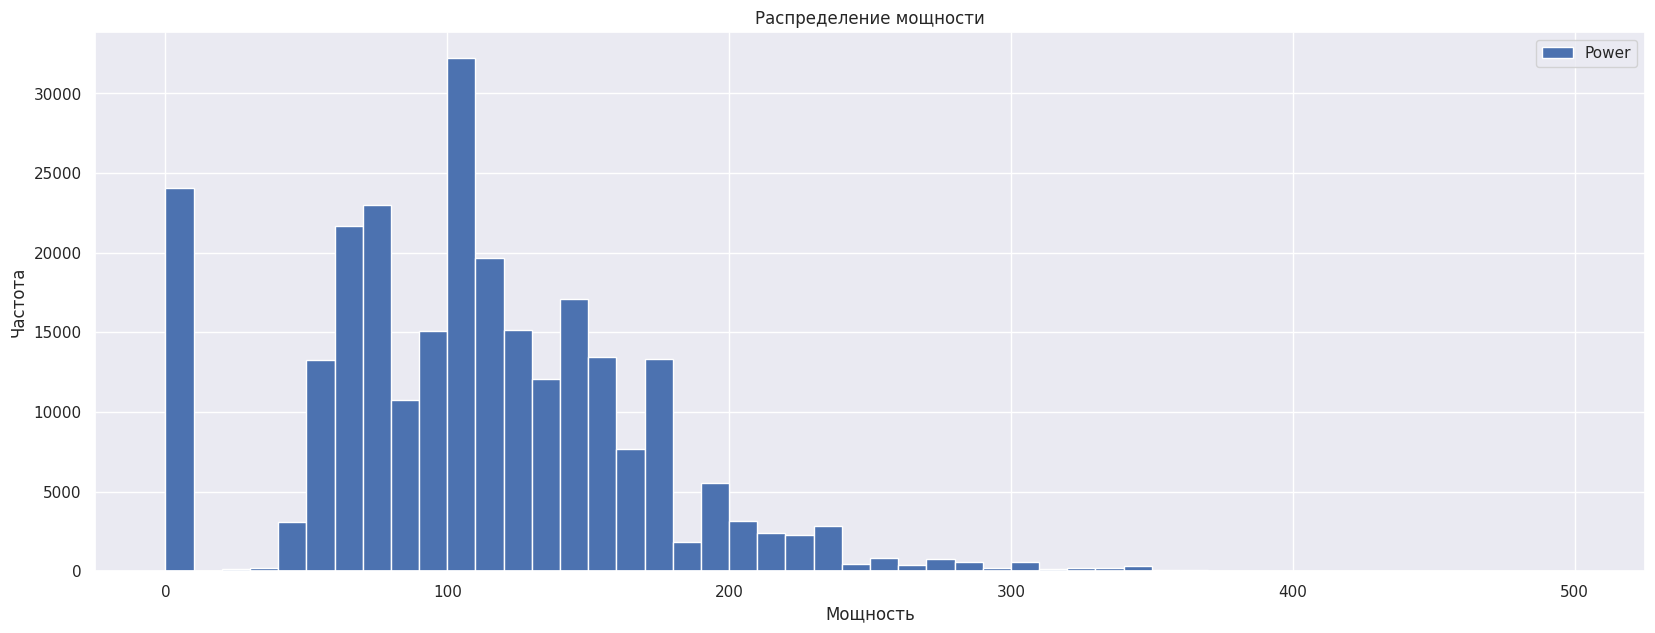

In [50]:
# проверим выбросы значений мощности
plt.figure(figsize=(10, 10))
df.boxplot(column='Power')
plt.title('Распределение мощности')
plt.ylabel('Мощность')
plt.ylim(0, 500)
plt.show()

# посмотрим на распределение мощности в пределах 500 л.с.
plt.figure(figsize=(20, 7))
df['Power'].plot(kind='hist',
                 bins=50,
                 grid=True,
                 range=(0, 500),
                 legend=True
            )
plt.title('Распределение мощности')
plt.ylabel('Частота')
plt.xlabel('Мощность')
plt.show()

In [51]:
# проверим долю аномально высоких значений мощности
print(df[df['Power'] > 250].shape[0] / df.shape[0])

# проверим долю аномально низких значений мощности
df[(df['Power'] < 30) &
   (df['Power'] > 0)
].shape[0] / df.shape[0]

0.01629007029380171


0.0010327346738782201

Нулевые значения мощности отнесем к пропускам. Попробуем заполнить их на этапе обработки пропусков.

In [52]:
# удалим аномально высокие и низкие значения мощности
df = df[
        (
         (df['Power'] <= 250) &
         (df['Power'] >= 30)) |
        (df['Power'] == 0)
    ]

# проверим результат
df.shape[0]

260719

#### Этап 1.6.5. Обработка месяца регистрации

In [53]:
# найдем долю нулевых значений месяца
df[df['RegistrationMonth'] == 0].shape[0] / df.shape[0]

0.08313164748253868

Доля нулевых значений месяца довольно велика. Посчитаем их за пропуски. Оставим нулевые значения как есть, покольку нет возможности корректно заполнить их, а удаление 9% строк будет слишком существенным.

### Этап 1.7. Обработка пропусков

In [54]:
# напишем функцию для расчета доли пропусков по столбцам
def col_na_ratio():
    for col in [
            'VehicleType',
            'Gearbox',
            'Model',
            'FuelType',
            'Repaired'
            ]:
        print('Доля пропусков по столбцу',
              col,
              ':',
              df[df[col].isna()].shape[0] / df.shape[0]
        )

In [55]:
# проверим доли пропусков по столбцам
col_na_ratio()

Доля пропусков по столбцу VehicleType : 0.055592419424744646
Доля пропусков по столбцу Gearbox : 0.03893080289507094
Доля пропусков по столбцу Model : 0.04297730506790836
Доля пропусков по столбцу FuelType : 0.06916258500531224
Доля пропусков по столбцу Repaired : 0.1788630671335806


Доля пропусков в столбцах VehicleType, Gearbox, Model, FuelType составляет значительное количество от общего числа строк, поэтому будет некорректно удалять эти пропуски.

Доля пропусков в столбце Repaired тоже значительна, поэтому проверим столбцы на корреляцию. Закодируем значения в Repaired. При обнаружении корреляции признаков с Repaired, попробуем заполнить пропуски в этом столбце:

In [56]:
# закодируем значения в столбце Repaired
# создадим пустой список
Repaired_ohe = []

# Наполним список закодированными значениями
for val in df['Repaired']:
    if val == 'no':
        Repaired_ohe.append(0)
    else:
        Repaired_ohe.append(1)

# Добавим закодированные значения в датасет
df['Repaired_ohe'] = Repaired_ohe

# Проверим результат
df['Repaired_ohe'].head()

0    1
2    1
3    0
4    0
5    1
Name: Repaired_ohe, dtype: int64

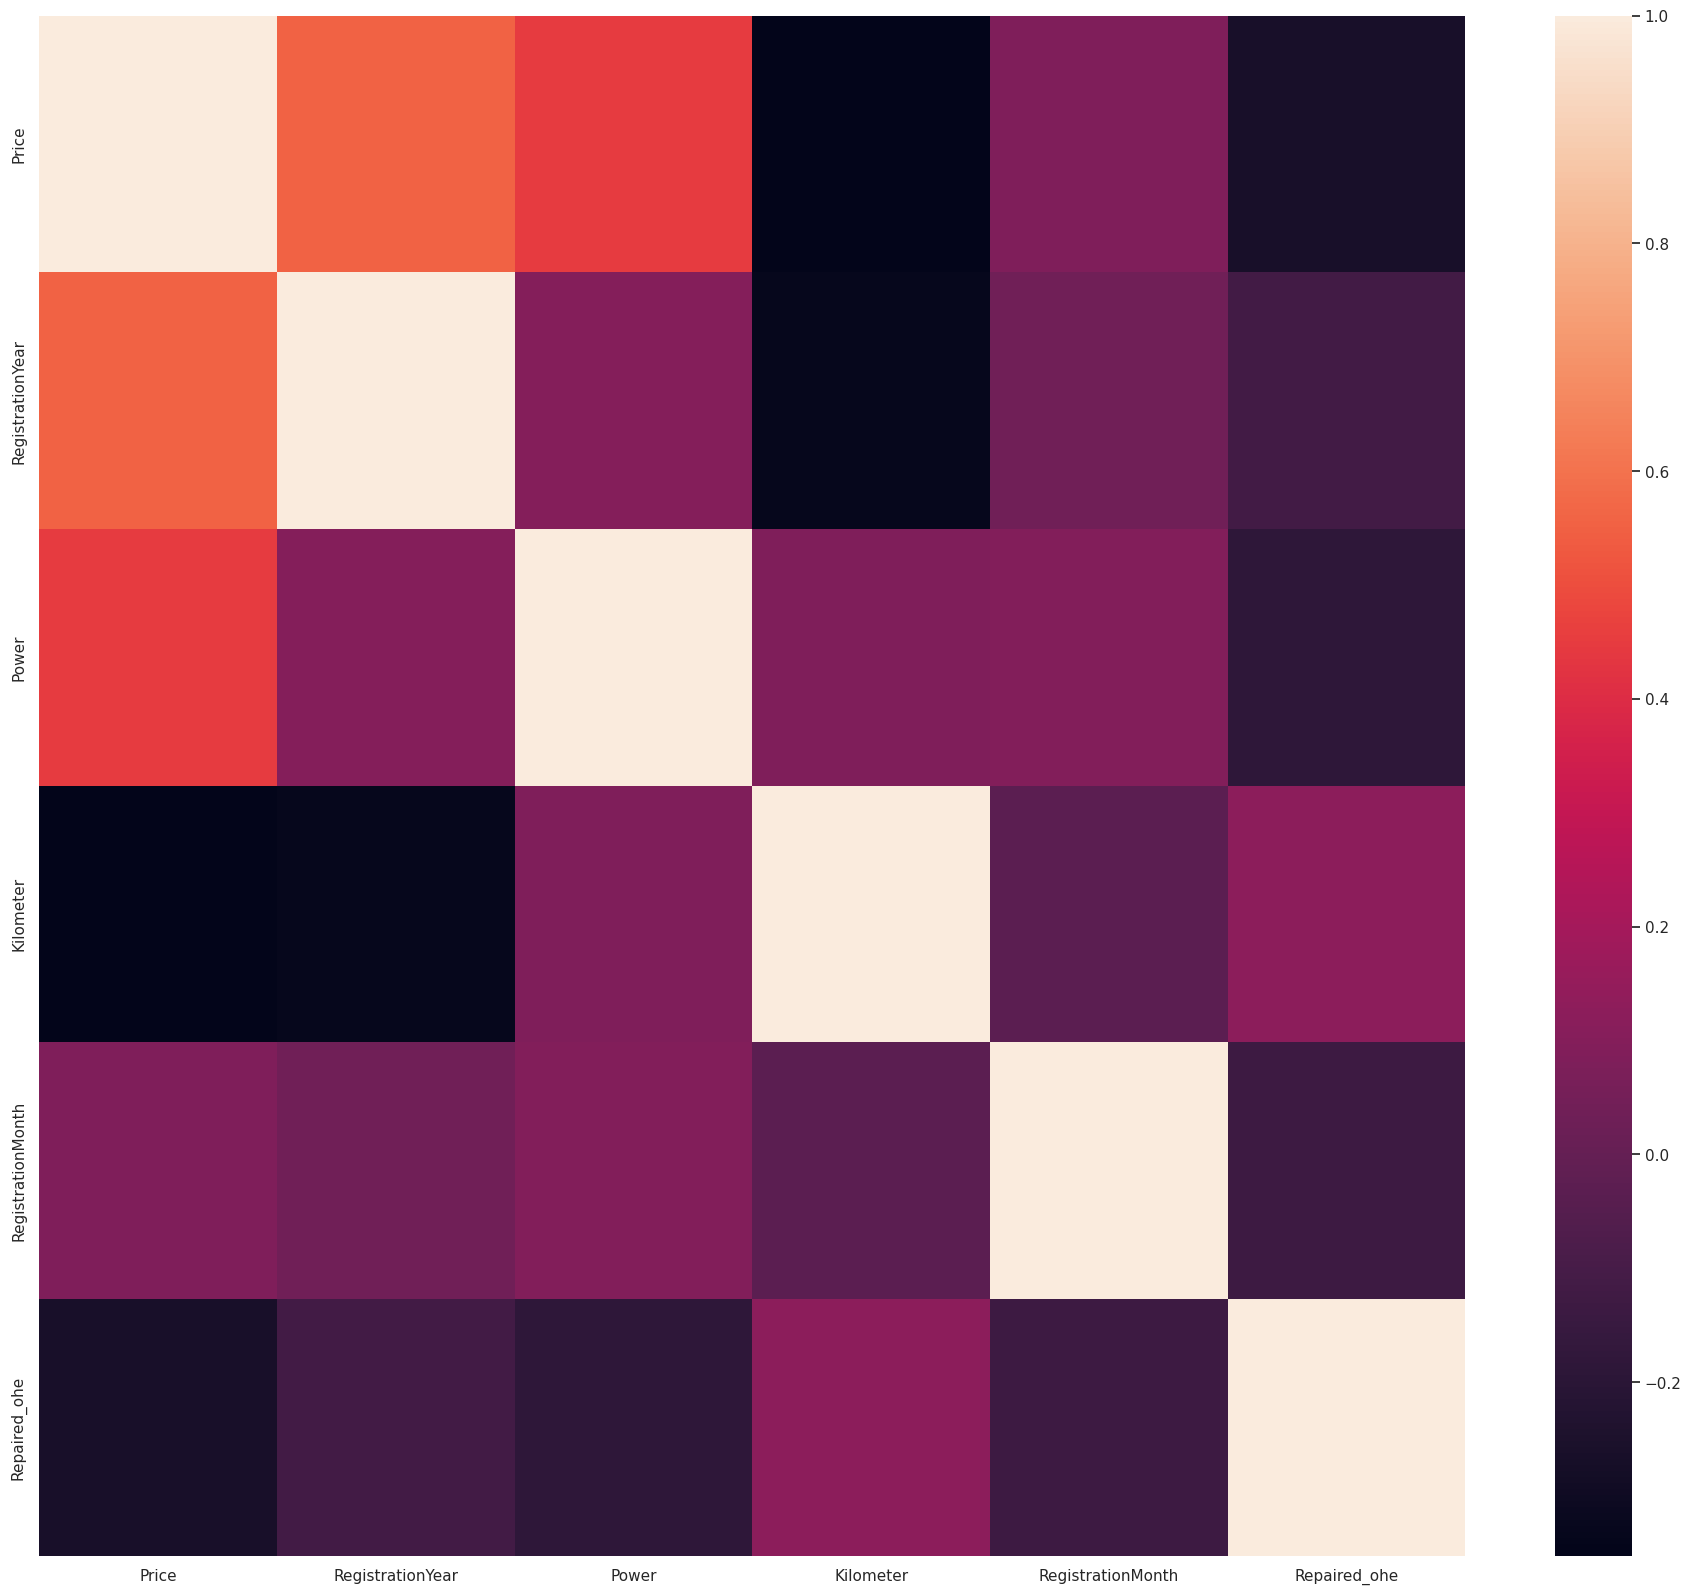

In [57]:
# проверим признаки на корреляцию
sns.set(rc = {'figure.figsize':(23,20)})
sns.heatmap(df.corr());

Значения в Repaired_ohe не корррелируют с другими признаками. Придется удалить пропуски в столбце Repaired:

In [58]:
# удалим пропуски в Repaired
df = df.dropna(subset=['Repaired'])

# удалим закодированные значеня Repaired
df = df.drop('Repaired_ohe', axis=1)

# проверим результат
df.shape[0]

214086

In [59]:
# напишем функцию для построчного заполнения пропусков в столбцах VehicleType, Gearbox, Model, FuelType
def fill_specs(row):

    # найдем пропуски по типу кузова
    if pd.isna(row['VehicleType']):

        # найдем совпадения по марке, типу коробки передач и модели. Заполним пропуски самым частотным значеним
        try:
            row['VehicleType'] = df.loc[
                (df['Brand'] == row['Brand']) &
                (df['Gearbox'] == row['Gearbox']) &
                (df['Model'] == row['Model']),
                'VehicleType'
                                ].value_counts().index[0]

        # если совпадений нет, оставим пропуск как есть
        except:
            row['VehicleType'] = None

    # найдем пропуски по типу коробки передач
    if pd.isna(row['Gearbox']):

        # найдем совпадения по марке, кузову и модели. Заполним пропуски самым частотным значеним
        try:
            row['Gearbox'] = df.loc[
                (df['Brand'] == row['Brand']) &
                (df['VehicleType'] == row['VehicleType']) &
                (df['Model'] == row['Model']),
                'Gearbox'
                            ].value_counts().index[0]

        # если совпадений нет, оставим пропуск как есть
        except:
            row['Gearbox'] = None

    # найдем пропуски по модели автомобиля
    if pd.isna(row['Model']):

        # найдем совпадения по марке, кузову и типу коробки передач. Заполним пропуски самым частотным значеним
        try:
            row['Model'] = df.loc[
                (df['Brand'] == row['Brand']) &
                (df['VehicleType'] == row['VehicleType']) &
                (df['Gearbox'] == row['Gearbox']),
                'Model'
                            ].value_counts().index[0]

        # если совпадений нет, оставим пропуск как есть
        except:
            row['Model'] = None

    # найдем пропуски по типу топлива
    if pd.isna(row['FuelType']):

        # найдем совпадения по марке, кузову, модели и типу коробки передач. Заполним пропуски самым частотным значеним
        try:
            row['FuelType'] = df.loc[
                (df['Brand'] == row['Brand']) &
                (df['VehicleType'] == row['VehicleType']) &
                (df['Model'] == row['Model']) &
                (df['Gearbox'] == row['Gearbox']),
                'FuelType'
                            ].value_counts().index[0]

        # если совпадений нет, оставим пропуск как есть
        except:
            row['FuelType'] = None

    return row

In [60]:
%%time

# заполним пропуски при помощи самописной функции
df = df.apply(fill_specs, axis=1)

CPU times: user 1min 15s, sys: 1.03 s, total: 1min 16s
Wall time: 1min 29s


In [61]:
# проверим результат заполнения пропусков
col_na_ratio()

Доля пропусков по столбцу VehicleType : 0.0
Доля пропусков по столбцу Gearbox : 0.0
Доля пропусков по столбцу Model : 0.0
Доля пропусков по столбцу FuelType : 0.0
Доля пропусков по столбцу Repaired : 0.0


Нулевые значения в столбце Power ранее мы приравняли в пропускам. Проверим долю этих значений от общего числа строк:

In [62]:
# найдем долю пропусков в Power
df[df['Power'] == 0].shape[0] / df.shape[0]

0.05888287884308175

In [63]:
# доля пропусков в Power незначительна, удалим их
df = df[df['Power'] != 0]

# проверим результат
df.shape[0]

201480

### Этап 1.8. Проверка обработки данных

Финально проверим результаты обработки данных:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201480 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              201480 non-null  int64 
 1   VehicleType        201480 non-null  object
 2   RegistrationYear   201480 non-null  int64 
 3   Gearbox            201480 non-null  object
 4   Power              201480 non-null  int64 
 5   Model              201480 non-null  object
 6   Kilometer          201480 non-null  int64 
 7   RegistrationMonth  201480 non-null  int64 
 8   FuelType           201480 non-null  object
 9   Brand              201480 non-null  object
 10  Repaired           201480 non-null  object
dtypes: int64(5), object(6)
memory usage: 18.4+ MB


None

,3,4,5,6,10
Price,1500,3600,650,2200,2000
VehicleType,small,small,sedan,convertible,sedan
RegistrationYear,2001,2008,1995,2004,2004
Gearbox,manual,manual,manual,manual,manual
Power,75,69,102,109,105
Model,golf,fabia,3er,2_reihe,3_reihe
Kilometer,150000,90000,150000,150000,150000
RegistrationMonth,6,7,10,8,12
FuelType,petrol,gasoline,petrol,petrol,petrol
Brand,volkswagen,skoda,bmw,peugeot,mazda


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,201480.0,NaN,NaN,NaN,4212.726613,3510.341901,250.0,1400.0,3000.0,6200.0,14500.0
VehicleType,201480,8,sedan,59211,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,201480.0,NaN,NaN,NaN,2002.934629,5.262868,1987.0,1999.0,2003.0,2007.0,2016.0
Gearbox,201480,2,manual,164526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,201480.0,NaN,NaN,NaN,116.253137,43.990222,30.0,80.0,110.0,143.0,250.0
Model,201480,245,golf,17023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,201480.0,NaN,NaN,NaN,133018.140758,29655.647954,40000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,201480.0,NaN,NaN,NaN,6.14324,3.499563,0.0,3.0,6.0,9.0,12.0
FuelType,201480,7,petrol,134324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,201480,40,volkswagen,42908,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Полных дубликатов строк: 1027


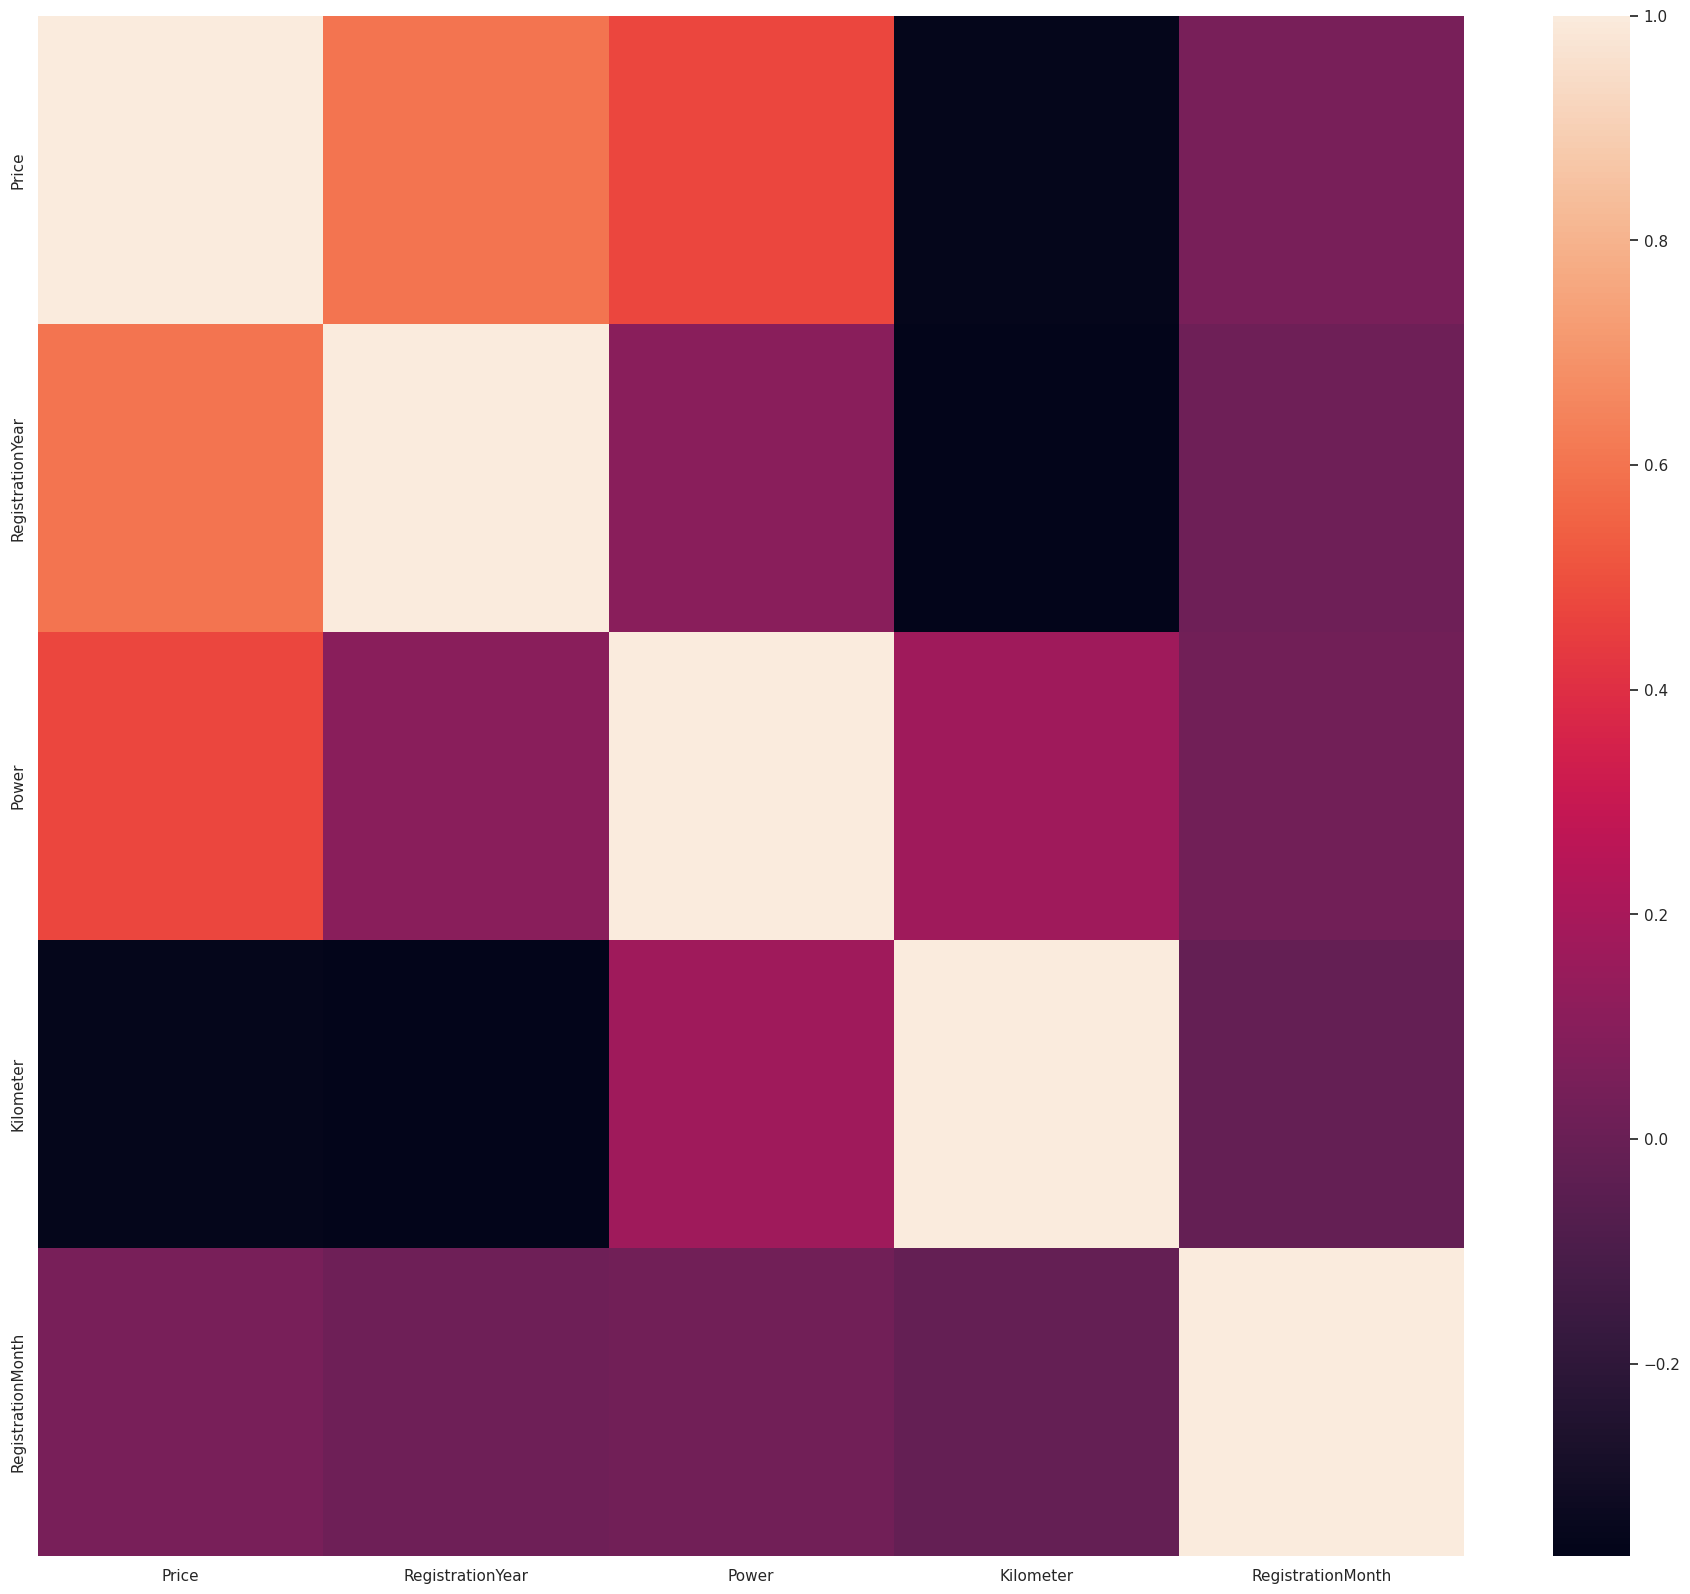

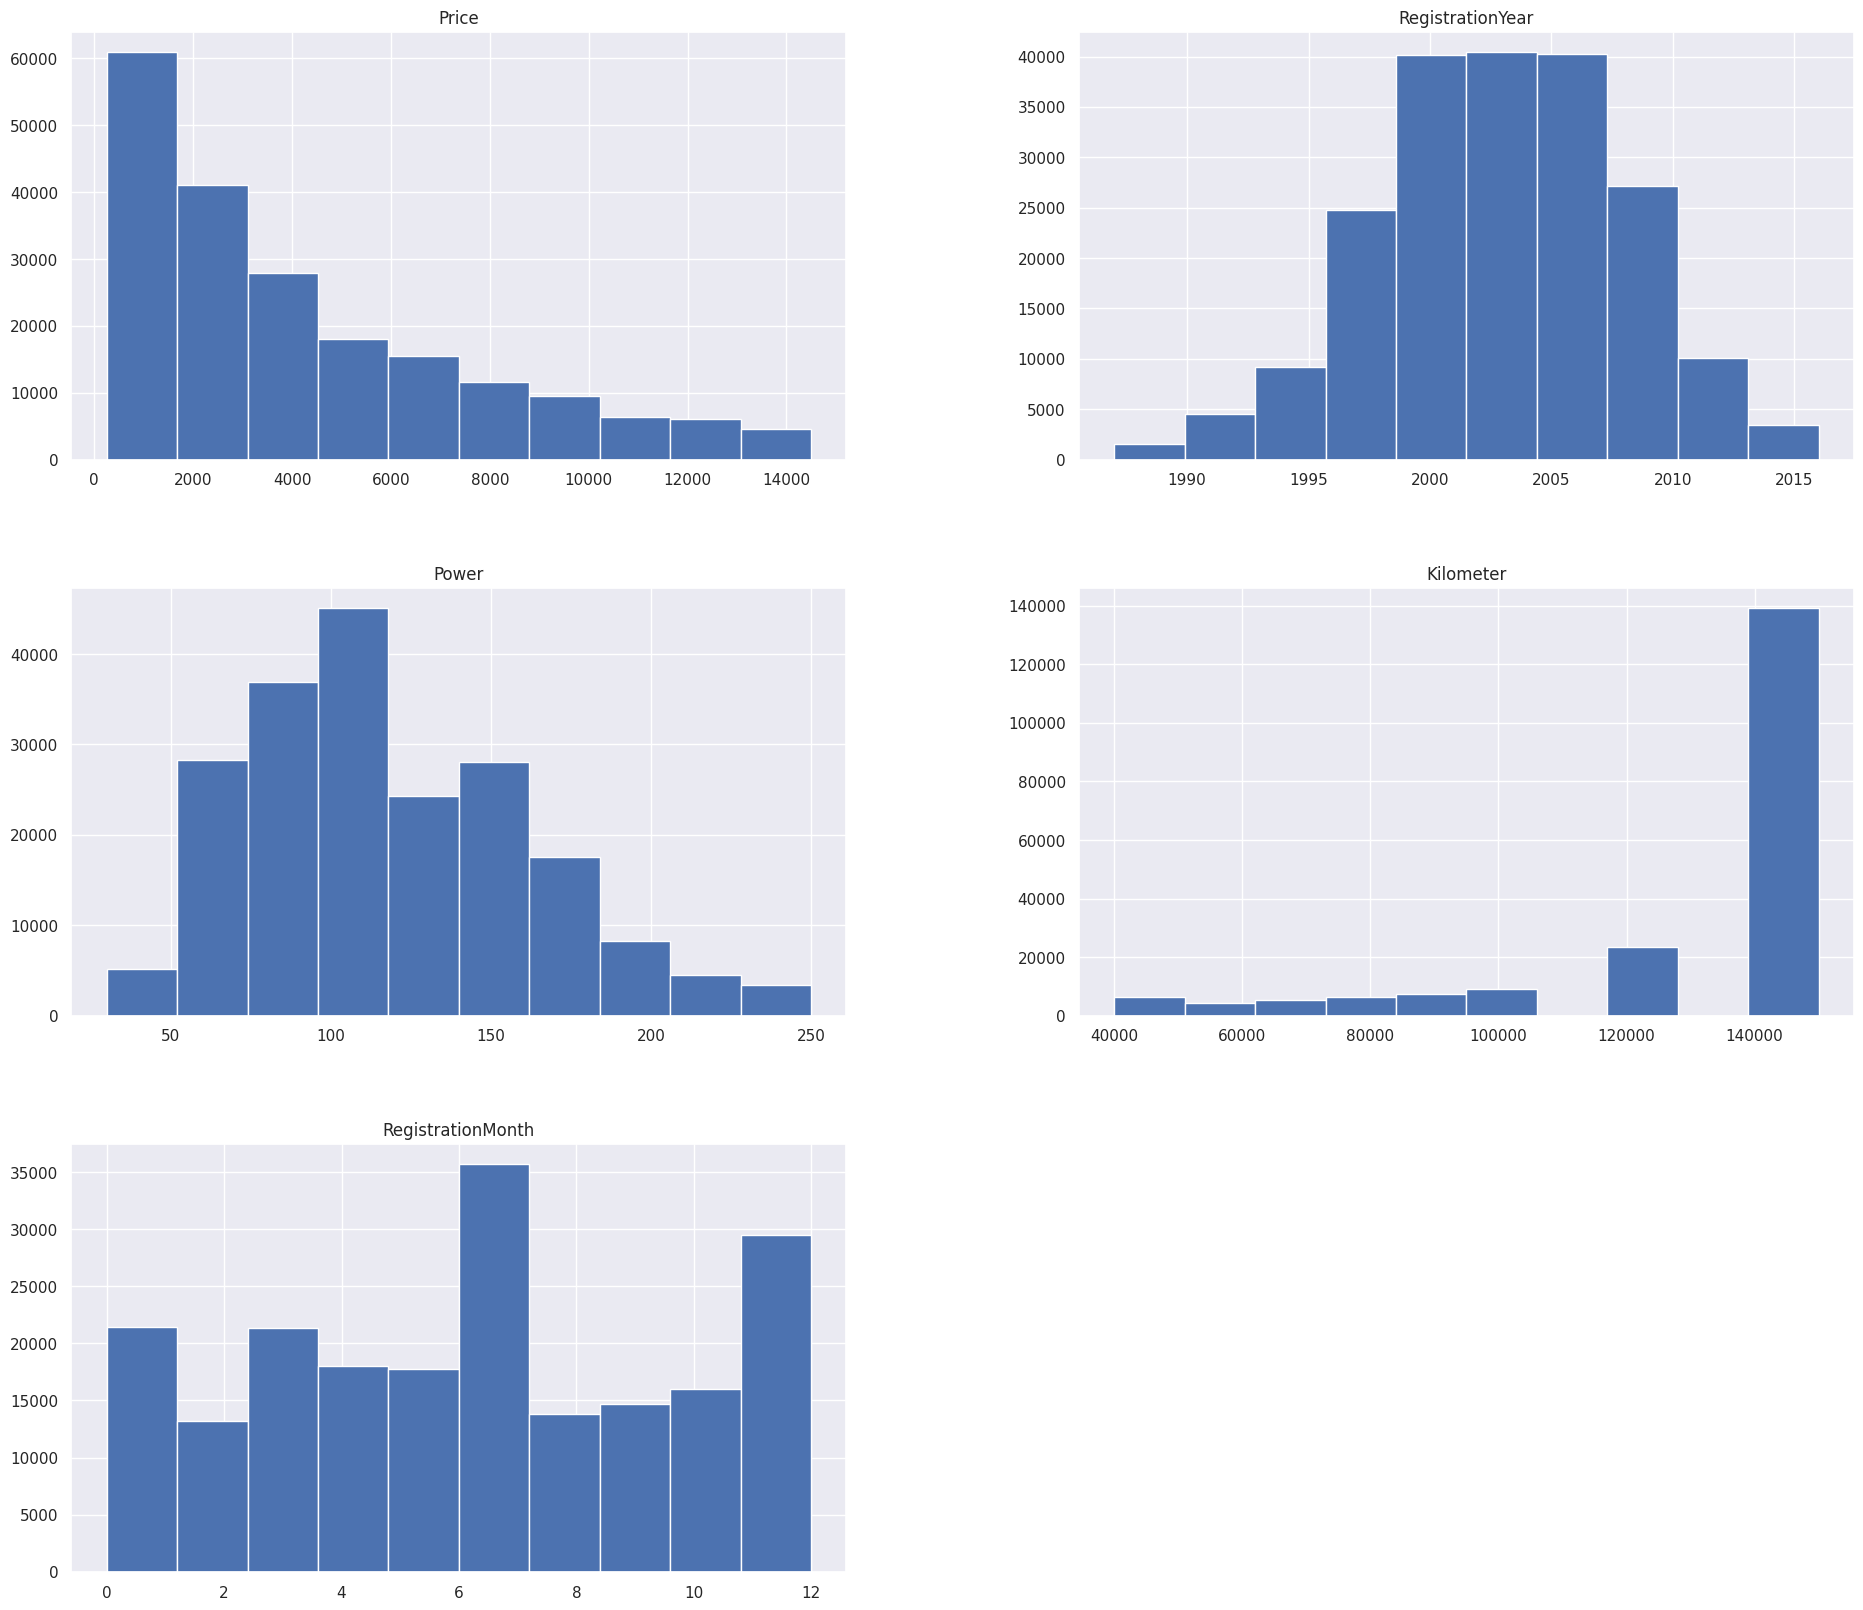

In [64]:
check(df)

В ходе заполнения пропусков изменился тип категориальных признаков с category на object и появились новые дубликаты строк. Дубликаты удалим, тип категориальных признаков поменяем на этапе подготовки признаков для градиентного бустинга.

In [65]:
# удалим полные дубликаты строк
df = df.drop_duplicates()

# проверим результат
df.shape[0]

200453

**Вывод:**

Мы провели обзор датасета: отметили особенности в данных, составили и реализовали план обработки:
- Удалили неиформативные признаки
- Успешно поменяли тип категориальных признаков с object на category
- Удалили все полные дубликаты строк
- Обработали аномалии: убрали выбросы и удалили неадекватные данные
- Обработали пропуски:
     - Часть пропусков заполнили по максимально похожим строкам
     - Прочие пропуски удалили

## Этап 2. Обучение моделей

### Этап 2.1. Подготовка признаков

In [66]:
# разделим признаки на тренировочную, валидационную и тестовую выборки
X_train, X_valid, X_test = np.split(
    df.drop(
        ['Price'],
        axis=1).sample(frac=1, random_state=RS),
    [int(.6*len(df.drop(['Price'], axis=1))),
     int(.8*len(df.drop(['Price'], axis=1)))
    ]
)

# разделим целевые признаки на выборки
y_train, y_valid, y_test = np.split(
    df['Price'].sample(frac=1, random_state=RS),
    [int(.6*len(df['Price'])),
     int(.8*len(df['Price']))
    ]
)

# проконтролируем размеры и размерность выборок
display(
    X_train.shape,
    X_valid.shape,
    X_test.shape,
    y_train.shape,
    y_valid.shape,
    y_test.shape
)

(120271, 10)

(40091, 10)

(40091, 10)

(120271,)

(40091,)

(40091,)

In [ ]:
# получим категориальные признаки для модели Ridge
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()

# добавим месяц регистрации
ohe_features_ridge.append('RegistrationMonth')

# проверим результат
ohe_features_ridge

['VehicleType',
 'Gearbox',
 'Model',
 'FuelType',
 'Brand',
 'Repaired',
 'RegistrationMonth']

In [ ]:
# получим категориальные признаки для модели случайного леса
ohe_features_rf = ohe_features_ridge.copy()

# исключим из признаков Model и Brand из-за большого количества значений, используем для них порядковое кодирование
ohe_features_rf.remove('Model')
ohe_features_rf.remove('Brand')

# проверим результат
ohe_features_rf

['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'RegistrationMonth']

In [ ]:
# получим численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()

# исключим из признаков RegistrationMonth
num_features.remove('RegistrationMonth')

# проверим результат
num_features

['RegistrationYear', 'Power', 'Kilometer']

### Этап 2.2. Модель Ridge

Создадим трансформер выборки для модели:

In [ ]:
# скопируем выборки для модели
X_train_ridge = X_train.copy()
X_valid_ridge = X_valid.copy()
X_test_ridge = X_test.copy()

# создадим трансформер для выборок
col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_ridge
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# проверим трансформер на тренировочной выборке
X_train_ridge = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.fit_transform(X_train_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)

# проверим результат
display(X_train_ridge.head())

# закодируем валидационную выборку
X_valid_ridge = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.transform(X_valid_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)

# проверим результат
display(X_valid_ridge.head())

# вернем тренировочную выборку в исходное состояние
X_train_ridge = X_train.copy()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,...,RegistrationMonth_6,RegistrationMonth_7,RegistrationMonth_8,RegistrationMonth_9,RegistrationMonth_10,RegistrationMonth_11,RegistrationMonth_12,RegistrationYear,Power,Kilometer
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.180538,-0.938971,0.575718
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.370314,1.062101,-2.119122
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.578568,-0.893492,-1.782267
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.180538,-0.347745,0.575718
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.009239,-0.006653,0.575718


,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,...,RegistrationMonth_6,RegistrationMonth_7,RegistrationMonth_8,RegistrationMonth_9,RegistrationMonth_10,RegistrationMonth_11,RegistrationMonth_12,RegistrationYear,Power,Kilometer
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.476333,-0.347745,0.575718
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.180538,-0.347745,0.575718
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.939644,0.766488,0.575718
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.370314,0.721009,0.575718
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.939644,-0.484182,0.575718


Используем пайплайн для подбора оптимальной модели с кросс-валидацией. Применим GridSearchCV:

In [ ]:
%%time

# создадим модель
model_ridge = Ridge(random_state=RS)

# создадим пайплайн
pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)

# выберем сетку гиперпараметров для модели
param_grid_ridge = {
    'ridge__alpha': np.arange(0, 0.21, 0.01),
}

# соберем все вместе, используем RMSE в качестве метрики
gs_ridge = GridSearchCV(
    pipeline_ridge,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# запустим обучение и подбор
gs_ridge.fit(X_train_ridge, y_train)

# найдем лучшую метрику модели и соответствующие гиперпараметры
gs_ridge_best_score = gs_ridge.best_score_ * -1
gs_ridge_best_params = gs_ridge.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge_best_score}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge_best_params}')

Fitting 5 folds for each of 21 candidates, totalling 105 fits
best_score: 1848.2040817883849
best_params: {'ridge__alpha': 0.12}
CPU times: user 2min 37s, sys: 2min 44s, total: 5min 22s
Wall time: 5min 24s


### Этап 2.3. Модель случайного леса

Создадим трансформер выборки для модели:

In [ ]:
# скопируем выборки для модели
X_train_rf = X_train.copy()
X_valid_rf = X_valid.copy()
X_test_rf = X_test.copy()

# создадим трансформер для выборок
col_transformer_rf = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ['Model', 'Brand']
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

# проверим трансформер на тренировочной выборке
X_train_rf = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_rf.fit_transform(X_train_rf),
    columns=col_transformer_rf.get_feature_names_out()
)

# проверим результат
display(X_train_rf.head())

# закодируем валидационную выборку
X_valid_rf = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_rf.transform(X_valid_rf),
    columns=col_transformer_rf.get_feature_names_out()
)

# проверим результат
display(X_valid_rf.head())

# вернем тренировочную выборку в исходное состояние
X_train_rf = X_train.copy()

,onehotencoder__VehicleType_convertible,onehotencoder__VehicleType_coupe,onehotencoder__VehicleType_other,onehotencoder__VehicleType_sedan,onehotencoder__VehicleType_small,onehotencoder__VehicleType_suv,onehotencoder__VehicleType_wagon,onehotencoder__Gearbox_manual,onehotencoder__FuelType_electric,onehotencoder__FuelType_gasoline,...,onehotencoder__RegistrationMonth_8,onehotencoder__RegistrationMonth_9,onehotencoder__RegistrationMonth_10,onehotencoder__RegistrationMonth_11,onehotencoder__RegistrationMonth_12,ordinalencoder__Model,ordinalencoder__Brand,standardscaler__RegistrationYear,standardscaler__Power,standardscaler__Kilometer
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,74.0,27.0,-0.180538,-0.938971,0.575718
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,201.0,20.0,-0.370314,1.062101,-2.119122
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,240.0,17.0,0.578568,-0.893492,-1.782267
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,242.0,24.0,-0.180538,-0.347745,0.575718
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,197.0,38.0,0.009239,-0.006653,0.575718


,onehotencoder__VehicleType_convertible,onehotencoder__VehicleType_coupe,onehotencoder__VehicleType_other,onehotencoder__VehicleType_sedan,onehotencoder__VehicleType_small,onehotencoder__VehicleType_suv,onehotencoder__VehicleType_wagon,onehotencoder__Gearbox_manual,onehotencoder__FuelType_electric,onehotencoder__FuelType_gasoline,...,onehotencoder__RegistrationMonth_8,onehotencoder__RegistrationMonth_9,onehotencoder__RegistrationMonth_10,onehotencoder__RegistrationMonth_11,onehotencoder__RegistrationMonth_12,ordinalencoder__Model,ordinalencoder__Brand,standardscaler__RegistrationYear,standardscaler__Power,standardscaler__Kilometer
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,115.0,38.0,2.476333,-0.347745,0.575718
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,242.0,24.0,-0.180538,-0.347745,0.575718
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.0,1.0,-0.939644,0.766488,0.575718
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,41.0,24.0,-0.370314,0.721009,0.575718
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,115.0,38.0,-0.939644,-0.484182,0.575718


Используем пайплайн для подбора оптимальной модели с кросс-валидацией. Применим RandomizedSearchCV для разумного времени подбора:

In [ ]:
%%time

# создадим модель
model_rf = RandomForestRegressor(random_state=RS)

# создадим пайплайн
pipeline_rf = make_pipeline(col_transformer_rf, model_rf)

# выберем сетку гиперпараметров для модели
param_grid_rf = {
    'randomforestregressor__max_depth': range(6, 12),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2)
}

# соберем все вместе, используем RMSE в качестве метрики
# при помощи cv=3 уменьшим количество фолдов до 3 для ускорения подбора гиперпараметров
rs_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RS,
    verbose=1,
    error_score='raise',
    cv=3
)

# запустим обучение и подбор
rs_rf.fit(X_train_rf, y_train)

# найдем лучшую метрику модели и соответствующие гиперпараметры
rs_rf_best_score = rs_rf.best_score_ * -1
rs_rf_best_params = rs_rf.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {rs_rf_best_score}')

# лучшие гиперпараметры
print(f'best_params: {rs_rf_best_params}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best_score: 1422.691423945631
best_params: {'randomforestregressor__min_samples_split': 3, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 11}
CPU times: user 29min 15s, sys: 2.2 s, total: 29min 17s
Wall time: 29min 21s


### Этап 2.4. Модели градиентного бустинга

Подготовим признаки для градиентного бустинга:

In [ ]:
# скопируем выборки для модели
X_train_grad = X_train.copy()
X_valid_grad = X_valid.copy()
X_test_grad = X_test.copy()

# получим категориальные признаки для модели градиентного бустинга
cat_features = X_train_grad.select_dtypes(include='object').columns.to_list()

# поменяем тип данных в категориальных признаках с object на category
X_train_grad[cat_features] = X_train_grad[cat_features].astype('category')
X_valid_grad[cat_features] = X_valid_grad[cat_features].astype('category')
X_test_grad[cat_features] = X_test_grad[cat_features].astype('category')

# проверим результат
display(X_train_grad.dtypes)
cat_features

VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                   int64
Model                category
Kilometer               int64
RegistrationMonth       int64
FuelType             category
Brand                category
Repaired             category
dtype: object

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Применим модель LGBMRegressor, используем GridSearchCV для подбора гиперпараметров:

In [ ]:
%%time

# создадим модель
model_lgbmr = LGBMRegressor(random_state=RS)

# выберем сетку гиперпараметров для модели
param_grid_lgbmr = {
    'learning_rate': (0.1, 0.2, 0.3),
    'max_depth': (7, 8, 9)
}

# соберем все вместе, используем RMSE в качестве метрики
gs_lgbmr = GridSearchCV(
    estimator=model_lgbmr,
    param_grid=param_grid_lgbmr,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise',
    verbose=100
)

# запустим обучение и подбор
gs_lgbmr.fit(
    X_train_grad,
    y_train,
    categorical_feature=cat_features,
    early_stopping_rounds=10,
    eval_set=(X_valid_grad, y_valid),
    verbose=100
)

# найдем лучшую метрику модели и соответствующие гиперпараметры
gs_lgbmr_best_score = gs_lgbmr.best_score_ * -1
gs_lgbmr_best_params = gs_lgbmr.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_lgbmr_best_score}')

# лучшие гиперпараметры
print(f'best_params: {gs_lgbmr_best_params}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START learning_rate=0.1, max_depth=7..............................
[100]	valid_0's l2: 1.56106e+06
[CV 1/5; 1/9] END learning_rate=0.1, max_depth=7;, score=-1272.688 total time=  30.5s
[CV 2/5; 1/9] START learning_rate=0.1, max_depth=7..............................
[100]	valid_0's l2: 1.56679e+06
[CV 2/5; 1/9] END learning_rate=0.1, max_depth=7;, score=-1247.180 total time=  28.4s
[CV 3/5; 1/9] START learning_rate=0.1, max_depth=7..............................
[100]	valid_0's l2: 1.56969e+06
[CV 3/5; 1/9] END learning_rate=0.1, max_depth=7;, score=-1245.356 total time= 1.7min
[CV 4/5; 1/9] START learning_rate=0.1, max_depth=7..............................
[100]	valid_0's l2: 1.56729e+06
[CV 4/5; 1/9] END learning_rate=0.1, max_depth=7;, score=-1256.361 total time= 2.1min
[CV 5/5; 1/9] START learning_rate=0.1, max_depth=7..............................
[100]	valid_0's l2: 1.56123e+06
[CV 5/5; 1/9] END learning_rate

Применим модель CatBoostRegressor, используя grid_search от CatBoost для подбора гиперпараметров:

In [ ]:
%%time

# создадим модель, используем RMSE в качестве метрики
model_cbr = CatBoostRegressor(
    random_state=RS,
    cat_features=cat_features,
    eval_metric='RMSE'
)

# выберем сетку гиперпараметров для модели
param_grid_cbr = {
    'learning_rate': (0.01, 0.1, 0.2, 0.3),
    'depth': range(4, 8)
}

# соберем все вместе
model_cbr.grid_search(
    param_grid_cbr,
    X_train_grad,
    y_train,
    cv=5,
    plot=True,
    refit=True,
    verbose=100,
    search_by_train_test_split=True
)

# найдем лучшую метрику модели и соответствующие гиперпараметры
gs_cbr_best_score = model_cbr.best_score_
gs_cbr_best_params = model_cbr.get_params()

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_cbr_best_score}')

# лучшие гиперпараметры
print(f'best_params: {gs_cbr_best_params}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5452.2644759	test: 5454.6727681	best: 5454.6727681 (0)	total: 125ms	remaining: 2m 4s
1:	learn: 5407.0005947	test: 5409.4438826	best: 5409.4438826 (1)	total: 200ms	remaining: 1m 39s
2:	learn: 5362.0538358	test: 5364.3883492	best: 5364.3883492 (2)	total: 268ms	remaining: 1m 29s
3:	learn: 5317.8946912	test: 5320.3368605	best: 5320.3368605 (3)	total: 324ms	remaining: 1m 20s
4:	learn: 5274.5365653	test: 5276.8932470	best: 5276.8932470 (4)	total: 388ms	remaining: 1m 17s
5:	learn: 5230.7889436	test: 5233.0345116	best: 5233.0345116 (5)	total: 455ms	remaining: 1m 15s
6:	learn: 5187.7705270	test: 5190.1355877	best: 5190.1355877 (6)	total: 516ms	remaining: 1m 13s
7:	learn: 5146.3455538	test: 5148.7862495	best: 5148.7862495 (7)	total: 569ms	remaining: 1m 10s
8:	learn: 5104.4086217	test: 5106.8559487	best: 5106.8559487 (8)	total: 624ms	remaining: 1m 8s
9:	learn: 5063.3095170	test: 5065.7204833	best: 5065.7204833 (9)	total: 702ms	remaining: 1m 9s
10:	learn: 5022.1696138	test: 5024.5347649	

**Вывод:**

Мы успешно подобрали гиперпараметры для четырех моделей: Ridge, RandomForestRegressor, LightGBMRegressor и CatbootRegressor. Далее проверим качество моделей и время на обучение и предсказание.

## Этап 3. Анализ моделей

### Этап 3.1. Проверка моделей

In [ ]:
# закодируем тренировочную выборку для Ridge
X_train_ridge = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.transform(X_train_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)

# закодируем тренировочную выборку для RandomForestRegressor
X_train_rf = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_rf.transform(X_train_rf),
    columns=col_transformer_rf.get_feature_names_out()
)

Обучим модели на оптимальных гиперпараметрах для замера чистого времени обучения (без подбора параметров) и времени предсказания.

In [ ]:
%%time

# задаем модель Ridge
ridge = Ridge(random_state=RS, alpha=0.01)

# запомним время начала обучения
start = time.time()

# обучим модель
ridge.fit(X_train_ridge, y_train)

# запомним время завершения обучения
end = time.time()

# найдем время обучения в секундах
fit_time_ridge = end - start

# запомним время начала предсказания
start = time.time()

# сделаем предсказания
ridge_prediction = ridge.predict(X_valid_ridge)

# запомним время завершения предсказания
end = time.time()

# найдем время предсказания в секундах
predict_time_ridge = end - start

# измерим RMSE модели на валидационной выборке
ridge_valid_score = mean_squared_error(y_valid, ridge_prediction, squared=False)

CPU times: user 1.44 s, sys: 2.05 s, total: 3.49 s
Wall time: 3.47 s


In [ ]:
%%time

# задаем модель RandomForestRegressor
rf = RandomForestRegressor(
    random_state=RS,
    min_samples_split=3,
    min_samples_leaf=1,
    max_depth=11
)

# запомним время начала обучения
start = time.time()

# обучим модель
rf.fit(X_train_rf, y_train)

# запомним время завершения обучения
end = time.time()

# найдем время обучения в секундах
fit_time_rf = end - start

# запомним время начала предсказания
start = time.time()

# сделаем предсказания
rf_prediction = rf.predict(X_valid_rf)

# запомним время завершения предсказания
end = time.time()

# найдем время предсказания в секундах
predict_time_rf = end - start

# измерим RMSE модели на валидационной выборке
rf_valid_score = mean_squared_error(y_valid, rf_prediction, squared=False)

CPU times: user 2min 48s, sys: 92.4 ms, total: 2min 48s
Wall time: 2min 51s


In [ ]:
%%time

# задаем модель LightGBMRegressor
lgbmr = LGBMRegressor(
    random_state=RS,
    learning_rate=0.2,
    max_depth=9,
    categorical_feature=cat_features
)

# запомним время начала обучения
start = time.time()

# обучим модель
lgbmr.fit(X_train_grad, y_train)

# запомним время завершения обучения
end = time.time()

# найдем время обучения в секундах
fit_time_lgbmr = end - start

# запомним время начала предсказания
start = time.time()

# сделаем предсказания
lgbmr_prediction = lgbmr.predict(X_valid_grad)

# запомним время завершения предсказания
end = time.time()

# найдем время предсказания в секундах
predict_time_lgbmr = end - start

# измерим RMSE модели на валидационной выборке
lgbmr_valid_score = mean_squared_error(y_valid, lgbmr_prediction, squared=False)

CPU times: user 31.4 s, sys: 256 ms, total: 31.7 s
Wall time: 31.9 s


In [ ]:
%%time

# задаем модель CatBoostRegressor
cbr = CatBoostRegressor(
    random_state=RS,
    cat_features=cat_features,
    eval_metric='RMSE',
    learning_rate=0.2,
    depth=7
)

# запомним время начала обучения
start = time.time()

# обучим модель
cbr.fit(X_train_grad, y_train)

# запомним время завершения обучения
end = time.time()

# найдем время обучения в секундах
fit_time_cbr = end - start

# запомним время начала предсказания
start = time.time()

# сделаем предсказания
cbr_prediction = cbr.predict(X_valid_grad)

# запомним время завершения предсказания
end = time.time()

# найдем время предсказания в секундах
predict_time_cbr = end - start

# измерим RMSE модели на валидационной выборке
cbr_valid_score = mean_squared_error(y_valid, cbr_prediction, squared=False)

0:	learn: 3056.1517745	total: 144ms	remaining: 2m 23s
1:	learn: 2705.2097136	total: 287ms	remaining: 2m 23s
2:	learn: 2414.1690414	total: 401ms	remaining: 2m 13s
3:	learn: 2190.9588892	total: 516ms	remaining: 2m 8s
4:	learn: 2017.3465936	total: 616ms	remaining: 2m 2s
5:	learn: 1885.0279909	total: 739ms	remaining: 2m 2s
6:	learn: 1785.1009233	total: 851ms	remaining: 2m
7:	learn: 1695.4798469	total: 996ms	remaining: 2m 3s
8:	learn: 1635.2627186	total: 1.11s	remaining: 2m 1s
9:	learn: 1587.5762210	total: 1.21s	remaining: 2m
10:	learn: 1551.0497990	total: 1.31s	remaining: 1m 58s
11:	learn: 1519.6623944	total: 1.42s	remaining: 1m 56s
12:	learn: 1496.0971198	total: 1.51s	remaining: 1m 54s
13:	learn: 1476.1421692	total: 1.58s	remaining: 1m 51s
14:	learn: 1459.8970516	total: 1.7s	remaining: 1m 51s
15:	learn: 1446.2467375	total: 1.77s	remaining: 1m 49s
16:	learn: 1436.6181931	total: 1.87s	remaining: 1m 48s
17:	learn: 1428.1237645	total: 1.95s	remaining: 1m 46s
18:	learn: 1420.3070625	total: 2.0

Создадим dummy-модель для проверки моделей на адекватность:

In [ ]:
# создадим dummy-модель
model_dummy = DummyRegressor()

# обучим dummy-модель и получим среднее значение
model_dummy.fit(X_train, y_train)
dummy_prediction = model_dummy.predict(X_valid)

# найдем RMSE dummy-модели
dummy_score = mean_squared_error(y_valid, dummy_prediction, squared=False)

# проверим результат
dummy_score

3495.7939717550985

Мы измерили время обучения и предсказания, а также RMSE каждой модели на валидационной выборке. Выберем лучшую модель на основе этих данных.

### Этап 3.2. Выбор лучшей модели

In [ ]:
# сравним модели по RMSE на валидационной выборке и времени операций
result = pd.DataFrame(
    [[None, None, dummy_score],
     [fit_time_ridge, predict_time_ridge, ridge_valid_score],
     [fit_time_rf, predict_time_rf, rf_valid_score],
     [fit_time_lgbmr, predict_time_lgbmr, lgbmr_valid_score],
     [fit_time_cbr, predict_time_cbr, cbr_valid_score]
    ],
    index=[
        'Dummy',
        'Ridge',
        'RandomForestRegressor',
        'LightGBMRegressor',
        'CatBoostRegressor'
    ],
    columns=[
        'fit_time',
        'predict_time',
        'RMSE'
    ]
)
result

,fit_time,predict_time,RMSE
Dummy,NaN,NaN,3495.793972
Ridge,3.360597,0.103781,1847.936617
RandomForestRegressor,171.001630,0.366920,1418.432544
LightGBMRegressor,31.503277,0.384983,1235.866855
CatBoostRegressor,100.382044,0.355772,1224.272232


- Все модели показали свою адекватность, превзойдя результат dummy-модели. Всем моделям удалось преодолеть порог 2500 по метрике RMSE, определенный задачей.

- Самой быстрой моделью ожидаемо оказалась линейная регрессия Ridge. Но эта модель показала худшее значение метрики. Ridge не будет оптимальным выбором в нашем случае.

- RandomForestRegressor - на третьем месте по RMSE и на последнем по времени работы. Эта модель не удовлетворяет нашим критериям.

- LightGBMRegressor показал второй результат по метрике, второй результат по скорости обучения и последний результат по скорости предсказания. Тем не менее скорость предсказания находится на хорошем уровне в 0,4 с.

- CatBoostRegressor показал лучший результат по RMSE. По времени обучения модель находится на третьем месте с приемлемым результатом около 1,5 минут. CatBoostRegressor также показал хорошее время предсказания около 0.29 с - по этому параметру модель находится на втором месте.

**Оптимальным выбором для решения нашей задачи будет LightGBMRegressor**, поскольку модель сочетает в себе высокое качество предсказания, отличную скорость обучения и хорошее время предсказания. Модель соответствует условиям задачи и показывает прекрасный результат.

## Этап 4. Тестирование лучшей модели

In [ ]:
# проверим RMSE модели на тестовой выборке
lgbmr_prediction_test = lgbmr.predict(X_test_grad)
lgbmr_test_score = mean_squared_error(y_test, lgbmr_prediction_test, squared=False)
lgbmr_test_score

1258.4878741463956

**Вывод:**

LightGBMRegressor подтвердил высокое качество предсказания на тестовой выборке - значение RMSE осталось на низком уровне.

**Общий вывод:**

- Мы провели обзор датасета: отметили особенности в данных, составили и реализовали план обработки:
    - Удалили неиформативные признаки
    - Успешно поменяли тип категориальных признаков с object на category
    - Удалили все полные дубликаты строк
    - Обработали аномалии: убрали выбросы и удалили неадекватные данные
    - Обработали пропуски:
         - Часть пропусков заполнили по максимально похожим строкам
         - Прочие пропуски удалили
     
- Успешно подобрали гиперпараметры для четырех моделей: Ridge, RandomForestRegressor, LightGBMRegressor и CatbootRegressor.

- Измерили время обучения и предсказания, а также RMSE каждой модели на валидационной выборке.

    - Все модели показали свою адекватность, превзойдя результат dummy-модели. Всем моделям удалось преодолеть порог 2500 по метрике RMSE, определенный задачей.

    - RandomForestRegressor - на третьем месте по RMSE и на последнем по времени работы. Эта модель не удовлетворяет нашим критериям.

    - LightGBMRegressor показал второй результат по метрике, второй результат по скорости обучения и последний результат по скорости предсказания. Тем не менее скорость предсказания находится на хорошем уровне в 0,4 с.

    - CatBoostRegressor показал лучший результат по RMSE. По времени обучения модель находится на третьем месте с приемлемым результатом около 1,5 минут. CatBoostRegressor также показал хорошее время предсказания около 0.29 с - по этому параметру модель находится на втором месте.

**Оптимальным выбором для решения нашей задачи будет LightGBMRegressor**, поскольку модель сочетает в себе высокое качество предсказания, отличную скорость обучения и хорошее время вредсказания. Модель соответсвует условиям задачи и показывает прекрасный результат.

LightGBMRegressor подтвердил высокое качество предсказания на тестовой выборке по метрике RMSE.